In [706]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.impute import SimpleImputer
%matplotlib inline 
from sklearn.svm import SVC, LinearSVC
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

## Objective

1. Perform thorough data cleaning to handle missing or inconsistent values.
2. Identify and analyze potential outliers in the dataset.
3. Predict survival rates using the cleaned data.


## Loading the data 


In [707]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

we are gonna combine both to facilitate looking and cleaning the data

In [708]:
combine = pd.DataFrame(pd.concat([test.assign(ind="test").copy(), train.assign(ind="train").copy()]))

Then to separate both of them later we will use:

In [709]:
## test, train = combine[combine["ind"].eq("test")], combine[combine["ind"].eq("train")]
## test = test.drop(columns=["ind"])
## train = train.drop(columns=["ind"])

## Looking at the data
What we will do:
    
    1- Tranforming the categorical variables into numeric variables
    2- Looking the correlation with survival

We also will look what aspects of the data can change the survival rate?/
I have some assumptions and through data vizualization i will try to confirm them:
    
        - First class survived more.
        - Third class survived less.
        - Females had more chance of survival.
        - Titles can have change the rate of survival.
        - Cabin has has no relation with survival rate.
    

In [710]:
combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ind,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test,NaN


first I think that the Sex,Names(titles) can be important variables in this analysis so i will change the Sex from categorical to numerical:

First the easiest Sex:

In [711]:
combine["Sex"] = combine["Sex"].map({'male': 1, 'female': 2})

In [712]:
combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ind,Survived
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,test,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,363272,7.0000,NaN,S,test,NaN
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,test,NaN
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,test,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,3101298,12.2875,NaN,S,test,NaN


Second the titles:

In [713]:
for row in combine.Name:
    combine['Title'] = combine['Name'].str.extract(r"([A-Za-z]+)\.", expand=False)

Now we just need to map the titles:

In [714]:
print(combine.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona' 'Don' 'Mme'
 'Major' 'Lady' 'Sir' 'Mlle' 'Capt' 'Countess' 'Jonkheer']


### So far we will divide them in 3 categories:
    

    - 1. HIGHER SURVIVAL RATE(1)
        - Like: Countess, Dona, Mrs, Mlle and Mme
        
    - 2. CAN SURVIVE (2)
        - Like: 
    - 3. HAS A SLIGHTLY CHANCE (3)

In [715]:
for row in combine.Name:
    combine['Title'] = combine['Title'].replace(['Countess', 'Dona', 'Mrs','Mme','Mlle','Ms','Lady','Master','Miss'], 1)
    combine['Title'] = combine['Title'].replace(['Don','Sir','Dr','Rev','Mr','Jonkheer'], 2)
    combine['Title'] = combine['Title'].replace(['Major','Capt','Col'], 3)

/tmp/ipykernel_3577/1961136523.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combine['Title'] = combine['Title'].replace(['Major','Capt','Col'], 3)


In [716]:
combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ind,Survived,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,test,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,363272,7.0000,NaN,S,test,NaN,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,test,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,test,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,3101298,12.2875,NaN,S,test,NaN,1


In [717]:
columns_analysis = combine.select_dtypes(include=["number"]).columns
columns_analysis

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Survived', 'Title'],
      dtype='object')

In [718]:
combine_corr = pd.DataFrame(combine[columns_analysis].corr())
sort_corr = combine_corr.Survived
print(sort_corr)

PassengerId   -0.005007
Pclass        -0.338481
Sex            0.543351
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Survived       1.000000
Title         -0.552048
Name: Survived, dtype: float64


Let's put into a HEATMAP TO SEE BETTER:


In [719]:
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

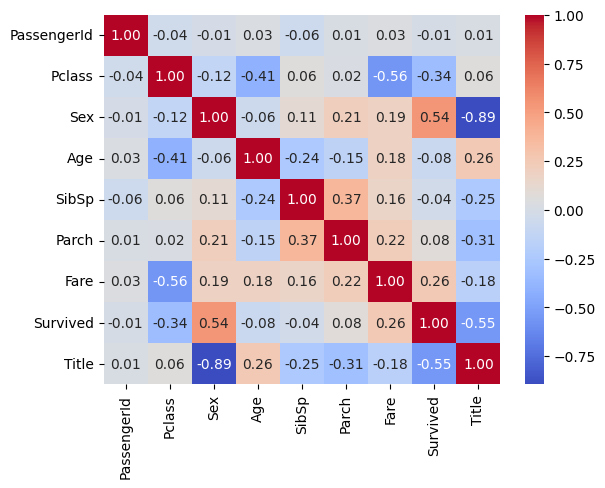

In [720]:
sns.heatmap(combine_corr,annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.show()

MAJOR CORRELATIONS WITH **SURVIVED**:

    - Title with 55%
    - Sex with 54%
    - Pclass with 34%.
    - Fare with 26%
    - Age with 8%

Now you understand why we modefied those columns to be numerical intead of categorical?
    
    We can understand it better!!

# Data Cleaning
     - Remove null values
     - Drop irrelevant columns

In [721]:
combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ind,Survived,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,test,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,363272,7.0000,NaN,S,test,NaN,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,test,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,test,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,3101298,12.2875,NaN,S,test,NaN,1


To let this better for our model we will change the categorical variables to numerical, but first we will drop some columns like:

    - Ticket
    - Cabin 
    - Embarked

Those two won't affect our result.

In [722]:
combine.drop(columns=["Cabin","Embarked","Ticket"], inplace=True)
combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,ind,Survived,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,test,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,7.0000,test,NaN,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,test,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,test,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,12.2875,test,NaN,1


**Age** is interesting to do so we will maintain even havin a low correlation with **Survived**

In [723]:
combine.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             1
ind              0
Survived       418
Title            0
dtype: int64

we have no more age with null values, so now we just need to do the predictions about the age.
But first we will need to separate both train and test sets:

In [724]:
#test, train = combine[combine["ind"].eq("test")], combine[combine["ind"].eq("train")]
#test = test.drop(columns=["ind"])
#train = train.drop(columns=["ind"])

In [725]:
train.shape

(891, 12)

In [726]:
test.shape

(418, 11)

We will use the columns Pclass, Parch, Fare and title:

In [727]:
column = ["Age"]
null_values = combine.loc[combine["Age"].isna(),"Age"]

rows_x = combine[['Pclass', 'Parch', 'Title']].dropna()
rows_y = combine[['Age']].dropna()

X_train_age_pred = rows_x.head(263)
y_train_age_pred = rows_y.head(263)
X_test_age_pred = combine.loc[combine['Age'].isna(), ['Pclass', 'Parch', 'Title']] 

model = LinearRegression().fit(X_train_age_pred ,y_train_age_pred)
predict_ages= model.predict(X_test_age_pred)
combine.loc[combine['Age'].isna(), 'Age'] = predict_ages

print(predict_ages)

[[29.31430008]
 [30.67168887]
 [29.31430008]
 [32.24921207]
 [30.53523537]
 [29.31430008]
 [29.45075358]
 [29.31430008]
 [29.38252683]
 [29.31430008]
 [30.60346212]
 [29.31430008]
 [29.31430008]
 [29.38252683]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [30.53523537]
 [33.96318876]
 [29.31430008]
 [29.45075358]
 [29.45075358]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [30.67168887]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [32.24921207]
 [29.45075358]
 [30.53523537]
 [30.53523537]
 [29.45075358]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [32.24921207]
 [30.53523537]
 [29.31430008]
 [29.31430008]
 [32.24921207]
 [30.53523537]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [29.45075358]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [30.53523537]
 [29.31430008]
 [29.31430008]
 [29.31430008]
 [29.45075358]
 [29.31430008]
 [29.31430

In [728]:
X_test_age_pred.shape


(263, 3)

In [729]:
X_train_age_pred.shape

(263, 3)

In [730]:
X_test_age_pred.head()

,Pclass,Parch,Title
10,3,0,2
22,1,0,1
29,3,0,2
33,3,2,1
36,3,0,1


In [731]:
X_train_age_pred.head()

,Pclass,Parch,Title
0,3,0,2
1,3,0,1
2,2,0,2
3,3,0,2
4,3,1,1


In [732]:
combine.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             1
ind              0
Survived       418
Title            0
dtype: int64

In [733]:
combine.shape

(1309, 11)

In [734]:
combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,ind,Survived,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,test,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,7.0000,test,NaN,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,test,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,test,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,12.2875,test,NaN,1


In [735]:
test, train = combine[combine["ind"].eq("test")], combine[combine["ind"].eq("train")]
test = test.drop(columns=["ind"])
train = train.drop(columns=["ind"])

In [736]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             1
Survived       418
Title            0
dtype: int64

In [737]:
train.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Survived       0
Title          0
dtype: int64

Let's if we have some null value

In [738]:
combine.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             1
ind              0
Survived       418
Title            0
dtype: int64

we have just a single Fare value, We can manually insert him.


In [739]:
combine[combine["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,ind,Survived,Title
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,NaN,test,NaN,2


he is the third class so he must had payed less than **69.55** like you can see here:

In [740]:
grouped = combine.groupby(['Pclass'])['Fare'].max()
print(grouped)

Pclass
1    512.3292
2     73.5000
3     69.5500
Name: Fare, dtype: float64


In [756]:
test["Fare"] = test["Fare"].fillna(69.55)

Now that we don't have null values we can start modelling our model:

In [757]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Survived       418
Title            0
dtype: int64

In [758]:
train.isnull().sum()


PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Survived       0
Title          0
dtype: int64

In [759]:
train.shape

(891, 10)

In [760]:
test.shape

(418, 10)

In [761]:
train.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Survived       0
Title          0
dtype: int64

In [762]:
print(test.isna().head())

   PassengerId  Pclass   Name    Sex    Age  SibSp  Parch   Fare  Survived  \
0        False   False  False  False  False  False  False  False      True   
1        False   False  False  False  False  False  False  False      True   
2        False   False  False  False  False  False  False  False      True   
3        False   False  False  False  False  False  False  False      True   
4        False   False  False  False  False  False  False  False      True   

   Title  
0  False  
1  False  
2  False  
3  False  
4  False  


In [763]:
test.isnull()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Survived,Title
0,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
413,False,False,False,False,False,False,False,False,True,False
414,False,False,False,False,False,False,False,False,True,False
415,False,False,False,False,False,False,False,False,True,False
416,False,False,False,False,False,False,False,False,True,False


In [764]:
combine.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,ind,Survived,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,test,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,7.0000,test,NaN,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,test,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,test,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,12.2875,test,NaN,1
5,897,3,"Svensson, Mr. Johan Cervin",1,14.0,0,0,9.2250,test,NaN,2
6,898,3,"Connolly, Miss. Kate",2,30.0,0,0,7.6292,test,NaN,1
7,899,2,"Caldwell, Mr. Albert Francis",1,26.0,1,1,29.0000,test,NaN,2
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",2,18.0,0,0,7.2292,test,NaN,1
9,901,3,"Davies, Mr. John Samuel",1,21.0,2,0,24.1500,test,NaN,2


In [765]:
train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Survived       float64
Title            int64
dtype: object

In [766]:
combine.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
ind              0
Survived       418
Title            0
dtype: int64

In [767]:
column = ["Survived"]
x_train = train.drop(["PassengerId", "Survived", "Name"], axis=1).select_dtypes(include=['number'])
y_train = train["Survived"]
x_test = test.drop(["PassengerId","Survived","Name"],axis=1).select_dtypes(include=['number'])
model = LinearRegression().fit(x_train, y_train)
predict = model.predict(x_test)
predictions = model.predict(x_test) 
rounded_predictions = predictions.round().astype(int)
print(rounded_predictions)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [768]:
combine.loc[combine['Survived'].isna(), 'Survived'] = rounded_predictions

Now we are done:

In [769]:
combine.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
ind            0
Survived       0
Title          0
dtype: int64

In [771]:
sub = pd.Series(rounded_predictions, index=test['PassengerId'],name='Survived')
sub.shape

(418,)

In [772]:
sub.to_csv("LinearReg.csv",header=True)